In [1]:
# import datetime
import backtrader as bt
import pandas as pd
import calendar
from datetime import datetime
import empyrical as ep
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
def option_expiration(date):
    day = 21 -(calendar.weekday(date.year, date.month, 1) + 4) % 7
    return datetime(date.year, date.month, day)

In [3]:
print(option_expiration(datetime.now()))

2025-11-19 00:00:00


In [4]:
class SampleStrategy(bt.Strategy):
    params = (
        ('period_day', 5),
        ('stop_loss', 0.01), # 1% stop loss
        ('take_profit', 0.01), # 1% take profit
    )

    def log(self, txt, dt=None):
        ''' Logging funciton for this strategy '''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.order = None
        self.sellprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return 
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('''BUY EXECUTED, Price: {order.executed.price:.2f},
                         Cost: {order.executed.value:.2f},
                         Comm: {order.executed.comm:.2f}''')
                self.buycomm = order.executed.comm
            else:
                self.sellprice = order.executed.price
                self.log(f'''SELL EXECUTED, Price: {order.executed.price:.2f},
                         Cost: {order.executed.value:.2f},
                         Comm: {order.executed.comm:.2f}''')
            self.bar_executed = len(self)
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return 
        self.log(f'OPERATION PROFIT, GROSS{trade.pnl:.2f}, NET{trade.pnlcomm:.2f}')

    def next(self):
        if self.order:
            return
        
        position = self.getposition().size
        status = None
        if (
            option_expiration(self.datas[0].datetime.datetime(0)).day
            == self.datas[0].datetime.datetime(0).day
        ):
            if self.datas[0].datetime.datetime(0).hour >= 13:
                status = "end"
                if position != 0:
                    self.close()
                    self.log("Expired and Create Close Order")

            if status != 'end':
                if not position:
                    if self.dataclose[0] > self.datahigh[-1]: # Breakout above the high
                        self.buy()
                        self.log('BUY ORDER CREATED')
                    elif self.dataclose[0] < self.datalow[-1]: # Breakout below the low
                        self.sell()
                        self.log('SELL ORDER CREATED')
                    
                # Exit Conditions
                if position > 0: # Long position
                    if (self.dataclose[0] > self.position.price * (1 + self.params.take_profit) or # Take profit
                        self.dataclose[0] < self.position.price * (1 - self.params.stop_loss)):
                        self.close()
                        self.log('CLOSE LONG POSITION')
                elif position < 0: # Short position
                    if (self.dataclose[0] < self.position.price * (1 - self.params.take_profit) or # Take profit
                        self.dataclose[0] > self.position.price * (1 + self.params.stop_loss)):
                        self.close()
                        self.log('CLOSE SHORT POSITION')


                        


In [5]:
cerebro = bt.Cerebro()
df = pd.read_csv('TXF_30.csv')
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.between_time('08:45', '13:45')
data_feed = bt.feeds.PandasData(
    dataname=df,
    name='TXF',
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=False
)


Starting Pofolio Value: 300000.00
2019-03-20T09:15:00, BUY ORDER CREATED
2019-03-20T09:45:00, BUY EXECUTED, Price: {order.executed.price:.2f},
                         Cost: {order.executed.value:.2f},
                         Comm: {order.executed.comm:.2f}
2019-03-20T13:15:00, Expired and Create Close Order
2019-03-20T13:45:00, SELL EXECUTED, Price: 10543.00,
                         Cost: 167000.00,
                         Comm: 200.00
2019-03-20T13:45:00, OPERATION PROFIT, GROSS5600.00, NET5200.00
2019-04-17T09:15:00, BUY ORDER CREATED
2019-04-17T09:45:00, BUY EXECUTED, Price: {order.executed.price:.2f},
                         Cost: {order.executed.value:.2f},
                         Comm: {order.executed.comm:.2f}
2019-04-17T13:15:00, Expired and Create Close Order
2019-04-17T13:45:00, SELL EXECUTED, Price: 11004.00,
                         Cost: 167000.00,
                         Comm: 200.00
2019-04-17T13:45:00, OPERATION PROFIT, GROSS5400.00, NET5000.00
2019-05-15T09:45:0

Start date,2019-03-04
End date,2020-02-27
Total months,11
,Backtest
Annual return,24.057%
Cumulative returns,23.0%
Annual volatility,9.249%
Sharpe ratio,2.38
Calmar ratio,20.51
Stability,0.90
Max drawdown,-1.173%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.17,2019-07-16,2019-08-21,2019-09-18,47
1,0.54,2019-10-15,2019-10-16,2019-11-20,27
2,0.26,2019-05-14,2019-05-15,2019-06-19,27
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


cum returns: 0.23000000000000043
mid: -0.011728395061728515
sharpe: 2.376659752242031


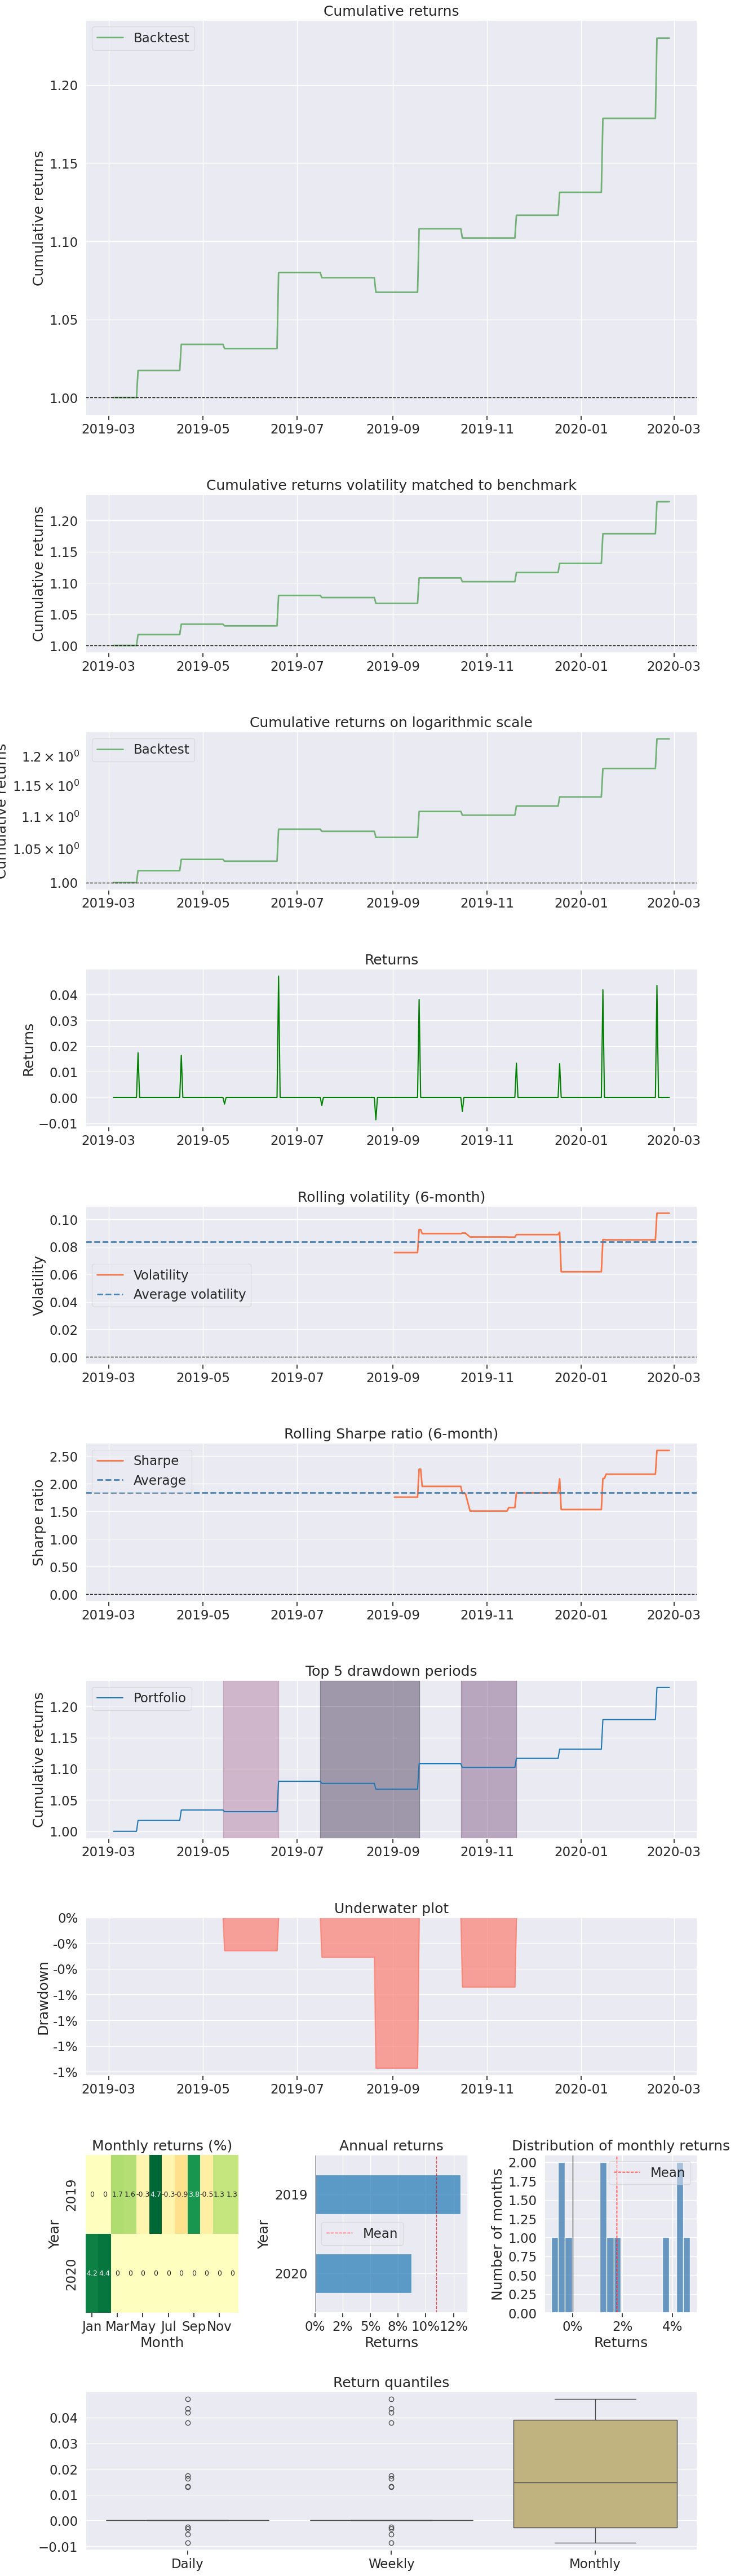

In [6]:
cerebro.adddata(data_feed, name='TXF')
cerebro.addstrategy(SampleStrategy)
cerebro.broker.setcash(300000.0)

cerebro.broker.setcommission(commission=200, margin=167000, mult=200)
print('Starting Pofolio Value: %0.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

pf.create_returns_tear_sheet(returns, positions=positions)
print(f'cum returns: {ep.cum_returns_final(returns)}')
print(f'mid: {ep.max_drawdown(returns)}')
print(f'sharpe: {ep.sharpe_ratio(returns)}')

In [7]:
a = 'awpeofia'
print(f'apeoi{a}')
print(f'')

apeoiawpeofia



In [8]:
df

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2019-03-04 09:15:00,2019-03-04 09:15:00,10390.0,10400.0,10308.0,10309.0,28947
2019-03-04 09:45:00,2019-03-04 09:45:00,10309.0,10343.0,10294.0,10315.0,27199
2019-03-04 10:15:00,2019-03-04 10:15:00,10314.0,10325.0,10301.0,10313.0,11852
2019-03-04 10:45:00,2019-03-04 10:45:00,10313.0,10324.0,10276.0,10280.0,15081
2019-03-04 11:15:00,2019-03-04 11:15:00,10279.0,10293.0,10279.0,10292.0,8394
...,...,...,...,...,...,...
2020-02-27 11:45:00,2020-02-27 11:45:00,11325.0,11344.0,11315.0,11329.0,8389
2020-02-27 12:15:00,2020-02-27 12:15:00,11329.0,11329.0,11282.0,11283.0,11232
2020-02-27 12:45:00,2020-02-27 12:45:00,11282.0,11295.0,11246.0,11260.0,15699


In [9]:
data_feed = bt.feeds.PandasData(
    dataname=df,
    name='TXF',
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=True
)

In [11]:
calendar.weekday(2025, 11, 11)

calendar.TUESDAY